In [4]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
url= 'https://bit.ly/2W21FY7'
hotstar= pd.read_csv(url)
hotstar.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,8/10/2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,8/11/2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,8/12/2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,8/11/2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,8/5/2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [8]:
docs= hotstar['Reviews'].fillna('').str.lower().str.replace('[^a-z #@]', '')
stopwords= nltk.corpus.stopwords.words('english')
stemmer= nltk.stem.PorterStemmer()

def clean_sentence(text):
    return' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stopwords])
docs_clean=docs.apply(clean_sentence)

#docs_clean.head()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(min_df=5)

train, test= train_test_split(docs_clean, test_size= 0.2, random_state=100)
vectorizer.fit(train)
train_dtm=vectorizer.transform(train)
test_dtm=vectorizer.transform(test)

train_x= pd.DataFrame(train_dtm.toarray(), columns= vectorizer.get_feature_names())
test_x= pd.DataFrame(test_dtm.toarray(), columns= vectorizer.get_feature_names())

train_x.shape, test_x.shape

((4042, 926), (1011, 926))

In [10]:
train_y= hotstar.iloc[train.index]['Sentiment_Manual']

test_y= hotstar.iloc[test.index]['Sentiment_Manual']

In [11]:
hotstar['Sentiment_Manual'].value_counts()/hotstar.shape[0]*100

Neutral     34.395409
Positive    34.296458
Negative    31.308134
Name: Sentiment_Manual, dtype: float64

In [14]:
model1= MultinomialNB()

model1.fit(train_x, train_y)

predict_classes1=model1.predict(test_x)

accuracy_score(test_y,predict_classes1)

0.7279920870425322

In [16]:
model2= GaussianNB()

model2.fit(train_x, train_y)

predict_classes2=model2.predict(test_x)

accuracy_score(test_y,predict_classes2)

0.56973293768546

In [19]:
hotstar['date']= pd.to_datetime(hotstar['Created_Date'])
hotstar.index= hotstar['date']


In [21]:
sentiment_dates= hotstar.groupby(['Created_Date', 'Sentiment_Manual']).size().reset_index()

sentiment_dates= sentiment_dates.rename(columns={0: 'Count'})

Text(0.5,1,'Trending of Sentiments')

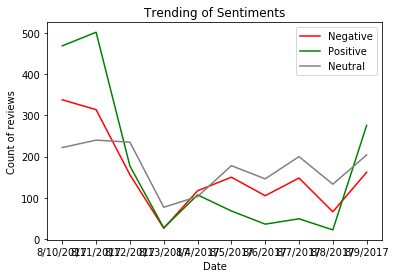

In [24]:
import matplotlib.pyplot as plt

positive_rows= sentiment_dates[sentiment_dates["Sentiment_Manual"]== 'Positive']
negative_rows= sentiment_dates[sentiment_dates["Sentiment_Manual"]== 'Negative']
Neutral_rows= sentiment_dates[sentiment_dates["Sentiment_Manual"]== 'Neutral']

plt.plot(negative_rows['Created_Date'], negative_rows['Count'], color='red')
plt.plot(positive_rows['Created_Date'], positive_rows['Count'], color='green')
plt.plot(Neutral_rows['Created_Date'], Neutral_rows['Count'], color='gray')
plt.legend(['Negative', 'Positive', 'Neutral'])
plt.xlabel('Date')
plt.ylabel('Count of reviews')
plt.title('Trending of Sentiments')

# Unsupervised Snetimental Analysis


## VADER(Valence Aware Dictionary and Sentiment Reasoner)

In [27]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


True

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti= SentimentIntensityAnalyzer()
senti.polarity_scores('i love india')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [29]:
senti.polarity_scores('love')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}

In [30]:
senti.polarity_scores('i LOVE india')

{'neg': 0.0, 'neu': 0.169, 'pos': 0.831, 'compound': 0.7125}

In [32]:
senti.polarity_scores('i LOVE india :)')

{'neg': 0.0, 'neu': 0.112, 'pos': 0.888, 'compound': 0.8374}

In [34]:
hotstar['sentiment_vader']=hotstar['Reviews'].apply(lambda v: senti.polarity_scores(v)['compound'])

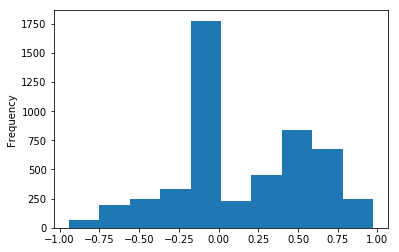

In [35]:
hotstar['sentiment_vader'].plot.hist()

In [36]:
def assign_sentiment(score):
    if score>0.25:
        return "Positive"
    elif score<-0.25:
        return "Negative"
    else:
        return 'Neutral'
    
hotstar['sentiment_vader']= hotstar['sentiment_vader'].apply(assign_sentiment)

hotstar['sentiment_vader'].value_counts()

Neutral     2149
Positive    2137
Negative     767
Name: sentiment_vader, dtype: int64

In [37]:
accuracy_score(hotstar['Sentiment_Manual'], hotstar['sentiment_vader'])

0.5513556303186226

In [40]:
api_key= 'UPhTA6R3r5ItZl3lj5oD4uX1V'
api_secret= '5ynPQBAKk94cUTGB2pxmRr3I4SDiWzrctbghYT9oPl056yToTv'

access_token='735546481189474304-EaikHxhKPhL6d4LDDPVX5UgckiKPrgW'
access_secret='ti24czV8dy4A0EvtmAvSkyhbA3e1bpgGrRrBUEjst1gnn'

In [39]:
!pip install tweepy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [41]:
import tweepy

auth= tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

api= tweepy.API(auth)
    

In [42]:
tweets= api.user_timeline('narendramodi', count=200)
len(tweets)

200

to find #'s we use api.search

In [51]:
df_tweets= pd.DataFrame()

for tweet in tweets:
    text= tweet.text
    retweets= tweet.retweet_count
    likes= tweet.favorite_count
    created_at= tweet.created_at
    #print(text, retweets, likes, created_at)
    #print('--------------------------------------')
    curr_tweet= {'text':text,'retweets':retweets, 'likes': likes, 'created_at':created_at}
    df_tweets= df_tweets.append(curr_tweet, ignore_index= True)
df_tweets.head()

,created_at,likes,retweets,text
0,2019-02-04 09:32:43,11865.0,2242.0,"Today, on #WorldCancerDay we reiterate our com..."
1,2019-02-04 09:24:58,17407.0,2956.0,Congratulated @DrKrishanMiddha Ji for the rema...
2,2019-02-04 09:23:29,25699.0,4914.0,I salute all those who are valiantly fighting ...
3,2019-02-03 16:37:58,27867.0,4585.0,The iconic Dal Lake is mesmerising! \n\nHad th...
4,2019-02-03 16:36:29,10653.0,2358.0,Had the wonderful opportunity of interacting w...


In [52]:
df_tweets.to_csv("narendra_modi.csv", index= False)

![modi image](namo.png)

## Hashtag Scrapping

In [56]:
df_tweets1= pd.DataFrame()
tweets1= api.search('#flipkart', count=200)
for tweet in tweets1:
    text= tweet.text
    retweets= tweet.retweet_count
    likes= tweet.favorite_count
    created_at= tweet.created_at
    user_name= tweet.user.name
    handler_name= tweet.user.screen_name
    user_desc= tweet.user.description
    #print(text, retweets, likes, created_at)
    #print('--------------------------------------')
    curr_tweet= {'text':text,'retweets':retweets, 'likes': likes, 'created_at':created_at, 
                'User Name': user_name, 'Handle':handler_name, 'User Description': user_desc}
    df_tweets1= df_tweets1.append(curr_tweet, ignore_index= True)
df_tweets1.head()

,Handle,User Description,User Name,created_at,likes,retweets,text
0,hujodaddy1,Fidei Defensor,Lutyens' Rasputin,2019-02-05 08:29:18,0.0,1.0,RT @ians_india: Retail giant #Walmart may exit...
1,Prabudh,"CEH, Webmaster, CAP, MCP and Penetration teste...",P҉r҉a҉b҉u҉d҉h҉ ҉1҉3҉3҉7҉,2019-02-05 08:27:02,0.0,0.0,"Had very bad experience with @Flipkart, we ord..."
2,Codenam65077297,,Codename,2019-02-05 08:25:20,0.0,0.0,"Had very bad experience with @Flipkart, we ord..."
3,1967Anil,,anil goel,2019-02-05 08:24:05,0.0,14.0,RT @ZeeNewsHindi: #Flipkart ने फुटमैट पर लगाई ...
4,ians_india,India's largest independent News Agency,IANS Tweets,2019-02-05 08:23:11,0.0,1.0,Retail giant #Walmart may exit #Flipkart after...


In [57]:
df_tweets1.shape

(99, 7)